<a href="https://colab.research.google.com/github/0ethel0zhang/quantcon2022/blob/main/CLINC150_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

You can refer to [this TensorFlow tutorial](https://www.tensorflow.org/hub/tutorials/tf2_text_classification) for how to import the data.

# 0. Setup

## 0.1 Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


## 0.2 Download CLINC150

CLINC150 is a new dataset that includes queries with intents and queries that are out-of-scope (OOS), i.e., queries that do not fall into any of the system's supported intents.

The CLINC150 dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the CLINC150 dataset to your machine (or the colab runtime):

In [ ]:
data = tfds.load(name = "clinc_oos", split = "test")

In [ ]:
sample_n = 100 #@param sample_n
text = [tfds.as_numpy(x["text"]) for x in data.take(sample_n)]
intent = [tfds.as_numpy(x["intent_name"]) for x in data.take(sample_n)]

## 0.3 Explore the data 

In [ ]:
print("Text entries: {}, intent entries: {}".format(len(text), len(intent)))

Training entries: 25000, test entries: 25000


Let's look at some of the text.

In [ ]:
text[:3]

[b'do you know how i can change my insurance policy',
 b'would you provide me with what the point of life is',
 b'my tires are filled enough or no']

# 1. Build the model

Building a clustering model requires three main architectural decisions:

* How to represent the text?
* Which clustering model to use?

## 1.1 Transform input

In this example, the input data consists of sentences. As suggested by TensorFlow, "One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.
"


Here are many [embeddings models](https://www.tensorflow.org/text/guide/word_embeddings) from [TensorFlow Hub](https://www.tensorflow.org/hub) that you can try. This turorial will use the Universal Language Encoder i.e. **Option 1** in the following list of light-weight embeddings:

* [universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder/4) "*The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.*"
* [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2) - 50-dimension embedding trained on English Google News 7B corpus
* [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - same as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with additional text normalization to remove punctuation. This can help to get better coverage of in-vocabulary embeddings for tokens on your input text.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - A larger model with an embedding dimension of 128 instead of  50.

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def plot_similarity(labels, features, rotation1, rotation2):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation1)
  g.set_yticklabels(labels, rotation=rotation2)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 0, 90)

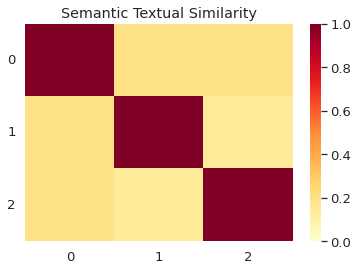

In [ ]:
plot_similarity(range(3), embed(sample[:3]), 0, 0)

In [ ]:
#@title transform to embeddings
embeddings = embed(text)

## 1.2 Build clustering model

Since text clusters are rarely of similar sizes and most of the time, we don't know the exact number of clusters there are, this tutorial focuses on clustering methodologies that deals with non-spherical data and do not require pre-determined number of clusters. Usually hierarchical clustering models are more suitable for these needs. One such model that we will cover in this tutorial is the AgglomerativeClustering model in sklearn.

In [ ]:
def cluster_with_cosine_way(embeddings, way = 'complete'):
  linkage_df = sch.linkage(embeddings, method = way, metric = "cosine")
  threshold = 0.7*max(linkage_df[:,2])
  ncluster = sum([x[2] > threshold for x in linkage_df]) + 1
  # create clusters
  hc = AgglomerativeClustering(
      n_clusters = ncluster, affinity = 'cosine', linkage = way)
  # save clusters for chart
  y_hc = hc.fit_predict(embeddings)
  return y_hc

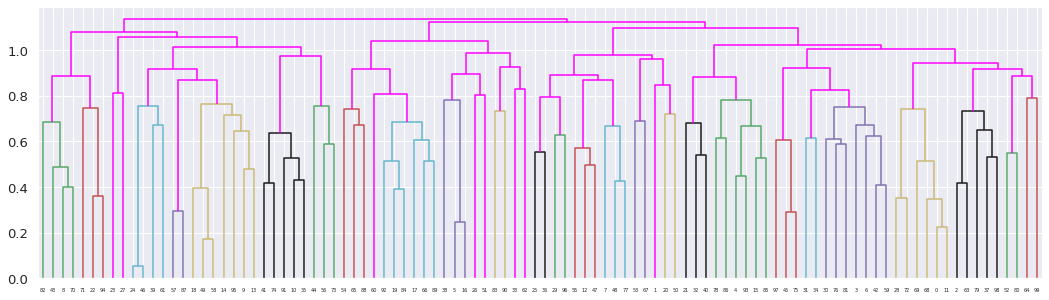

In [ ]:
#@title Create dendrogram graph
plt.figure(figsize = (18, 5))
dendrogram = sch.dendrogram(
    sch.linkage(embeddings, method='complete', metric = "cosine"), 
    leaf_rotation=0, above_threshold_color='magenta')
plt.hlines(1.25, 0, 1000, color = "magenta")

In [ ]:
y_hc = cluster_with_cosine_way(embeddings, "complete")

In [ ]:
output_df = pd.DataFrame([y_hc, text, intent]).T.rename(
    columns = dict(zip(range(3), ["cluster", "text", "intent"])))

## 1.3 Explore output

In [ ]:
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

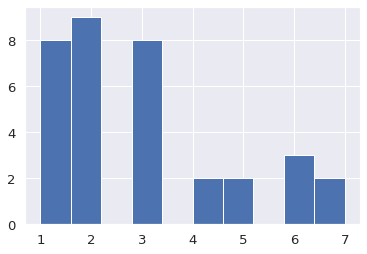

In [ ]:
# distribution of cluster size
plt.hist(output_df.cluster.value_counts());

In [ ]:
data_table.DataTable(
  output_df.sort_values("cluster")[["cluster", "text"]], 
  num_rows_per_page=10)

,cluster,text
99,0,b'give me a list of ingredients for making pasta'
64,0,b'will peas work instead of carrots'
5,1,"b'whisper mode , stop'"
38,1,"b'talk to you soon , bye !'"
16,1,b'please start whisper mode'
...,...,...
23,30,"b'yes , that is factual'"
51,31,b'set an alarm for 6 am tomorrow'
26,32,b'go back to the default settings please'
25,33,b'can i start calling you fred'


In [ ]:
#@title Get cluster centers (averages)
cluster_label_list = output_df.cluster.unique()
cluster_idx = output_df.reset_index().groupby("cluster")["index"].unique()

cluster_centers = {}
cluster_grouped = {}
for c in cluster_label_list:
  total_embeddings = [embeddings[i,:] for i in cluster_idx[c]]
  cluster_ctr = np.mean(total_embeddings, 0)
  cluster_centers[c] = cluster_ctr
  cluster_grouped[c] = total_embeddings

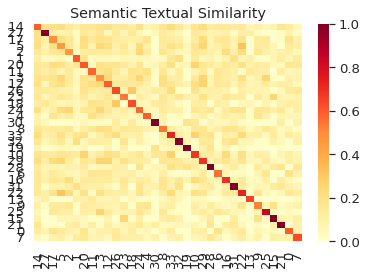

In [ ]:
#@title plot cluster correlations
plot_similarity(
    list(cluster_centers.keys()), list(cluster_centers.values()), 90, 0)

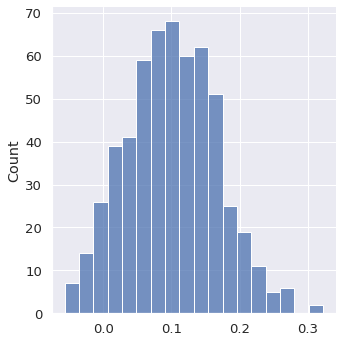

In [ ]:
sns.displot(
  upper_tri_indexing(
    np.inner(list(cluster_centers.values()), list(cluster_centers.values()))
  )
)

## 1.4 Summarize output

In [ ]:
import re
import string
import spacy
from collections import Counter
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [ ]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", "")
  more_stripping =  tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')
  # source: https://stackoverflow.com/questions/66044999/remove-stopwords-in-tensorflow-extended
  return tf.strings.regex_replace(more_stripping, r'\b(' + r'|'.join(sw_spacy) + r')\b\s*',"")

In [ ]:
def top_words(word_lst, n=2):
  try:
    return " * ".join([x[0] for x in Counter([w for g in word_lst for w in g]).most_common(n)])
  except:
    print("something wong")
    return ""

In [ ]:
output_df["norm_text"] = custom_standardization(text)
output_df["norm_word_lst"] = output_df["norm_text"].apply(lambda x: x.decode("utf-8").split(" "))

In [ ]:
#@title invetigate how well clusters aligned with intents
data_table.DataTable(
  output_df.groupby("cluster").agg({
      "norm_text":lambda x: "".join(str(x)),
      "intent":lambda x: "".join(str(x)),
      "text":np.size,
      "norm_word_lst":top_words}
    ).sort_values("text", ascending = False), 
  num_rows_per_page=10)

,norm_text,intent,text,norm_word_lst
cluster,,,,
3,9 b'money spend weekend'\...,9 b'spending_history'\n13 b'transac...,7,interest * bank
5,3 b'come got declined'\n6 ...,3 b'card_declined'\n6 b'r...,7,account * credit
2,4 b'shots date travel virgin islands'...,4 b'vaccines'\n15 b...,6,shots * trip
23,17 b'clue taco bell takes reservations'\n...,17 b'accept_reservations'\n19 b'accept_r...,6,reservations * reservation
14,0 b'know change insurance poli...,0 b'insurance_change'\n11 b'insurance_c...,6,insurance * plan
17,2 b'tires filled '\n37 ...,2 b'tire_pressure'\n37 b'o...,5,tires *
12,10 b'purchase'\n35 ...,10 b'transactions'\n35 b'pay...,5,date * expiration
8,24 b'want know vacation days '\n39 ...,24 b'pto_used'\n39 b'meeting_sch...,4,vacation * days
11,8 b'weather austin'\n43 b'weat...,8 b'weather'\n43 b'weather'\n70 b...,4,weather * austin
